### 1. Importing packages

In [ ]:
!pip install pandas-datareader==0.10.0

In [ ]:
!pip install 'ray[tune]'

In [ ]:
# data preprocessing
import datetime
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler
import numpy
import matplotlib.pyplot as plt

# machine learning
import torch
from torch.autograd import Variable
import torch.nn as nn

# hyperparameter tuning
import ray
from ray import tune

### 2. Loading dataset

In [ ]:
start_all = (2020, 1, 1) # 2020-01-01
end_train = (2020, 9, 30) # 2020-09-30
start_test = (2020, 10, 1) # 2020-10-01
end_all = (2020, 12, 31) # 2020-12-31

start_time_all = datetime.datetime(*start_all)
end_time_train = datetime.datetime(*end_train)
start_time_test = datetime.datetime(*start_test)
end_time_all = datetime.datetime(*end_all)

# loading Tesla, Inc. (TSLA) data from Yahoo Finance
stock_price_df = pdr.DataReader('TSLA', 'yahoo', start_time_all, end_time_all)

In [ ]:
stock_price_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001


In [ ]:
stock_price_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,666.090027,641.000000,642.98999,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.51001,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.00000,665.989990,22910800.0,665.989990
2020-12-30,696.599976,668.359985,672.00000,694.780029,42846000.0,694.780029
2020-12-31,718.719971,691.119995,699.98999,705.669983,49649900.0,705.669983


In [ ]:
# features (high price, low price, open price, close price, volume, adj close price)
X = stock_price_df
# response (adj close price)
y = stock_price_df.iloc[:, 5:6]

In [ ]:
# plotting parameters
plt.rcParams['figure.figsize'] = (32,18)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

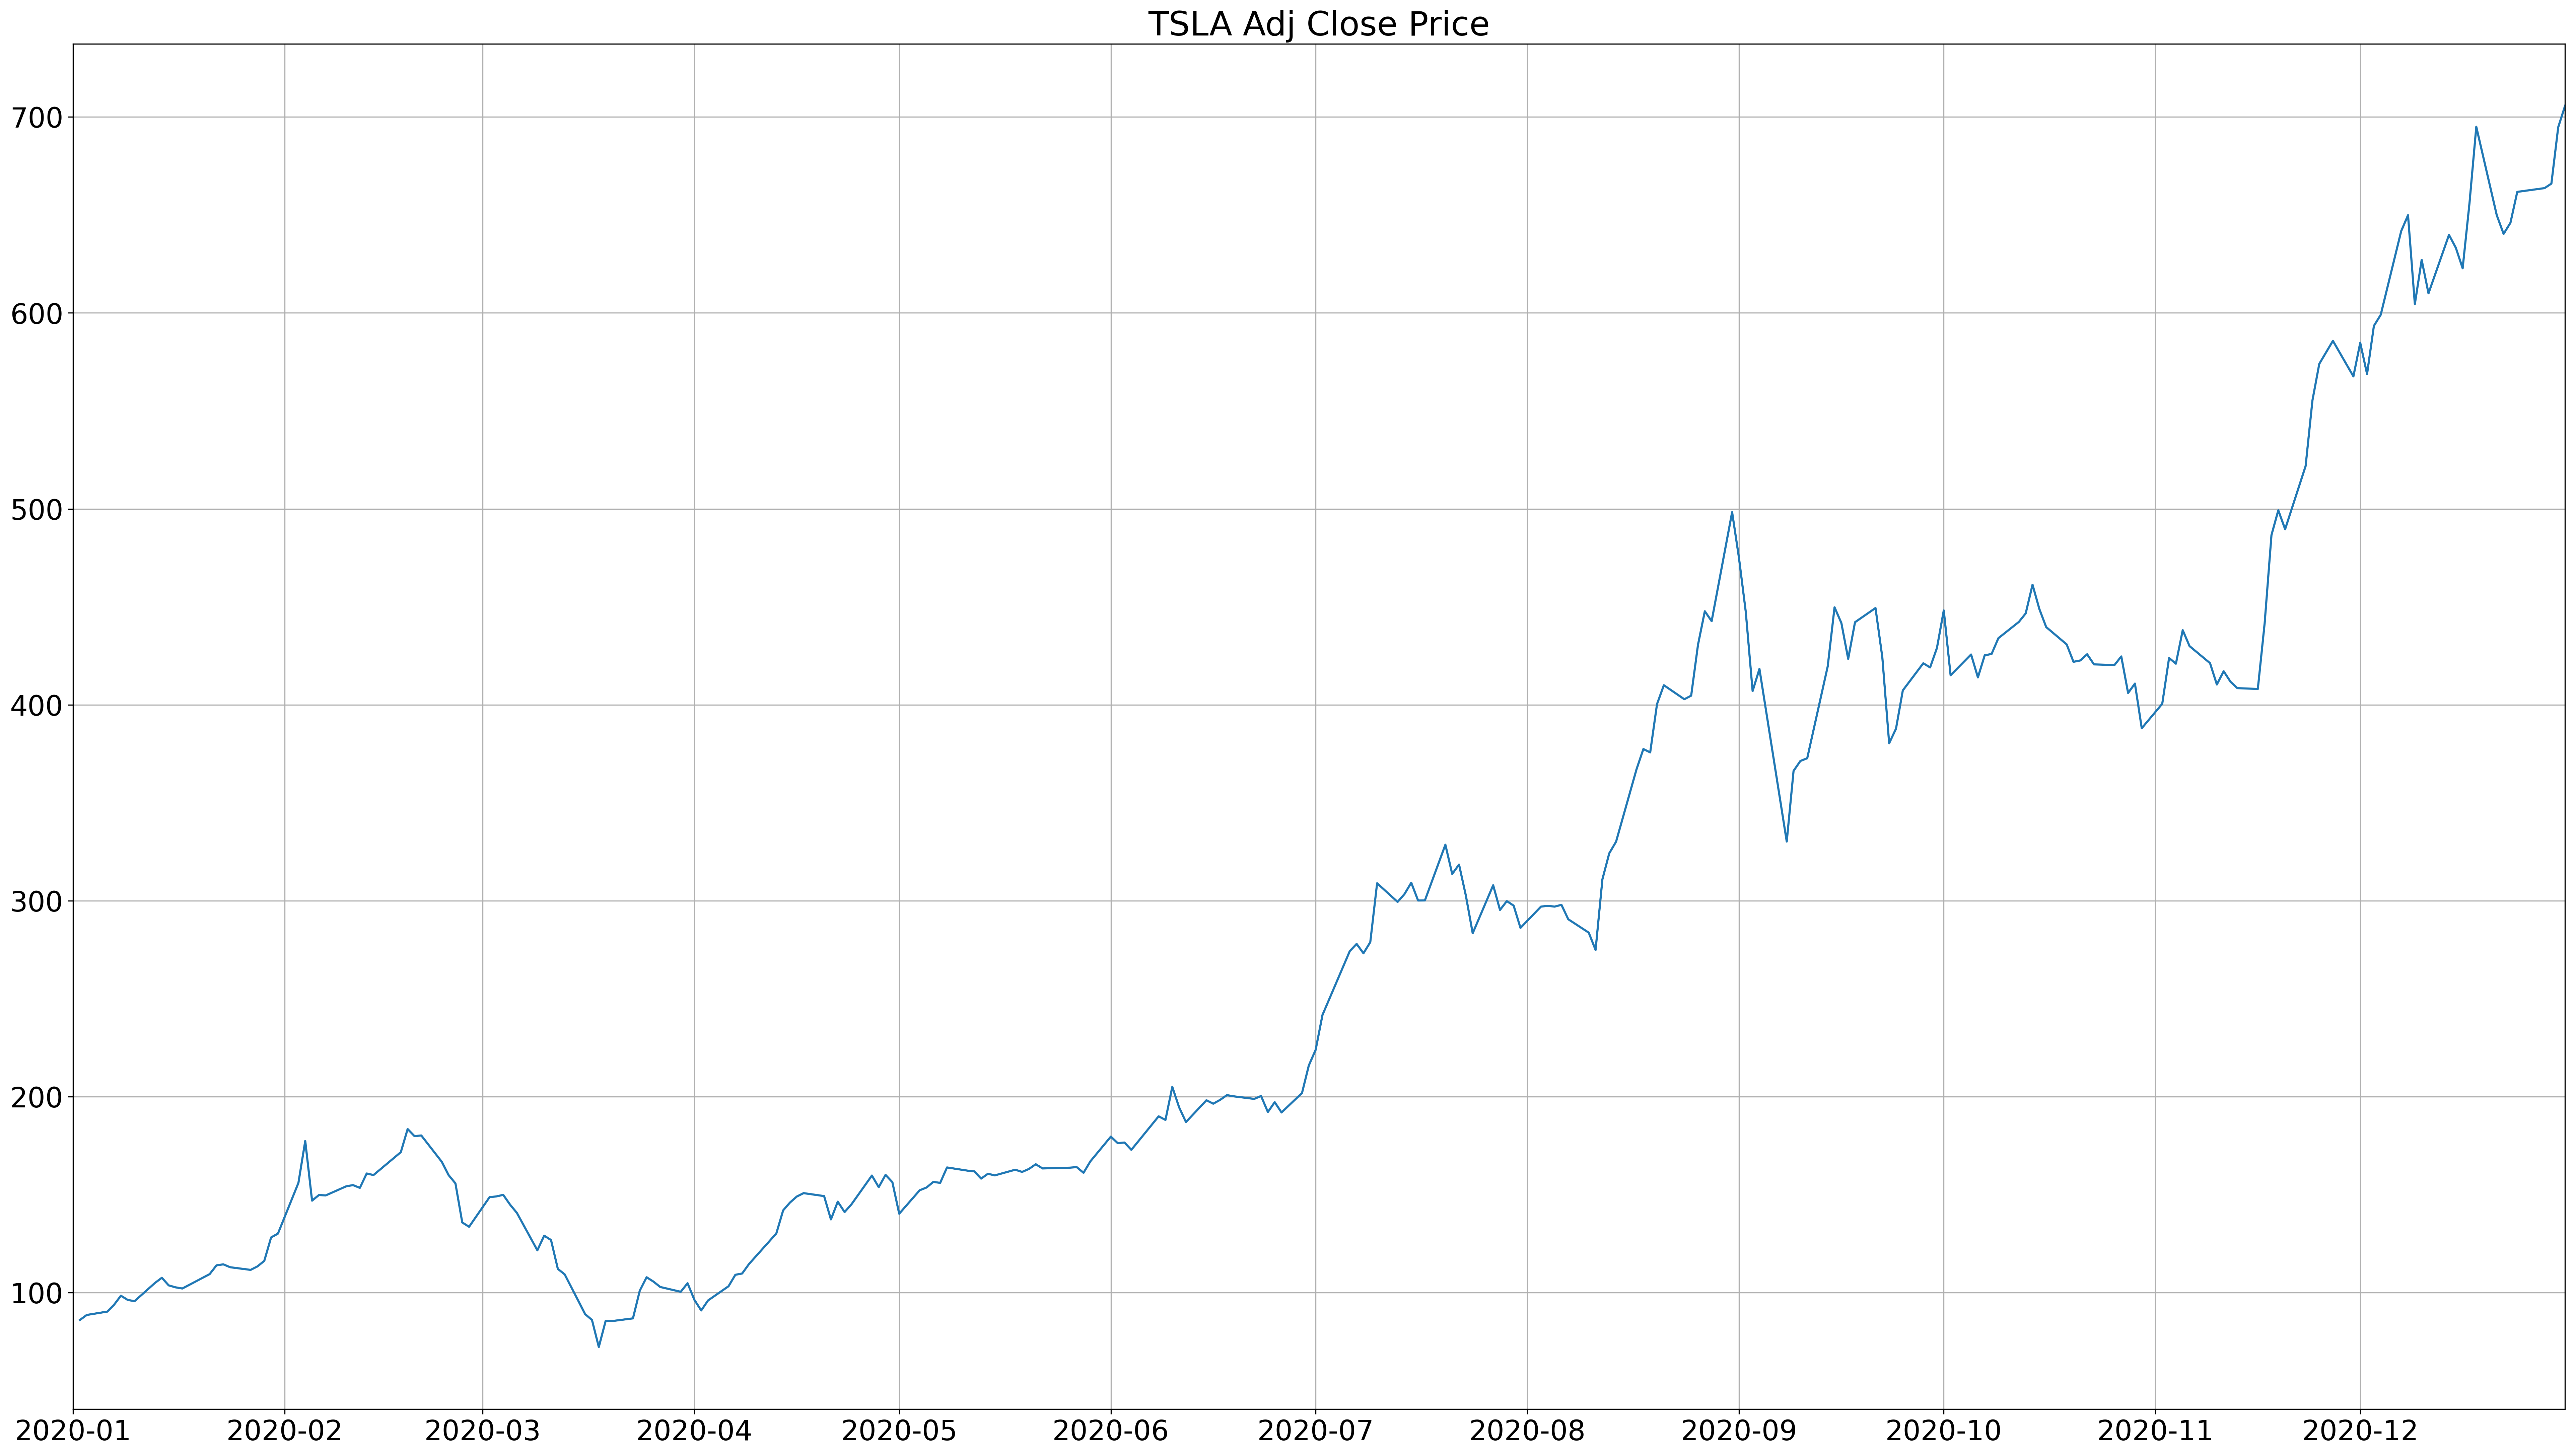

In [ ]:
# plotting TSLA adj close price from 2020-01-01 to 2020-12-31
plt.xlim(start_time_all, end_time_all)
plt.plot(stock_price_df.index.to_pydatetime(), y)
plt.title('TSLA Adj Close Price')
plt.show()

### 3. Scaling and converting data

In [ ]:
n_split = 189 # where to split training and testing data

In [ ]:
# scaling data
MMS = MinMaxScaler()
X_scaled = MMS.fit_transform(X)
y_scaled = MMS.fit_transform(y)

# 6 input variables
X_train = X_scaled[:n_split, :] # training using Jan - Sep data
X_test = X_scaled[n_split:, :] # testing trained model using Oct - Dec data

# output variable (adj close price)
y_train = y_scaled[:n_split, :]
y_test = y_scaled[n_split:, :]

print('Training Set Shape ', X_train.shape, y_train.shape)
print('Testing Set Shape  ', X_test.shape, y_test.shape)

Training Set Shape  (189, 6) (189, 1)
Testing Set Shape   (64, 6) (64, 1)


In [ ]:
# converting data to tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# reshaping X dataset
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Set Shape ', X_train_tensors.shape, y_train_tensors.shape)
print('Testing Set Shape  ', X_test_tensors.shape, y_test_tensors.shape)

Training Set Shape  torch.Size([189, 1, 6]) torch.Size([189, 1])
Testing Set Shape   torch.Size([64, 1, 6]) torch.Size([64, 1])


In [ ]:
# converting scaled data to tensors
X_scaled_tensors = Variable(torch.Tensor(X_scaled))
y_scaled_tensors = Variable(torch.Tensor(y_scaled))

# reshaping scaled X dataset
X_scaled_tensors = torch.reshape(X_scaled_tensors, (X_scaled_tensors.shape[0], 1, X_scaled_tensors.shape[1]))

y_data = y_scaled_tensors.data.numpy() # y dataset numpy conversion
y_data = MMS.inverse_transform(y_data) # y dataset reverse transformation

### 4. Building LSTM model

In [ ]:
# selecting gpu
device = torch.device('cuda')

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.num_layers = num_layers # number of layers
        self.num_classes = num_classes # number of classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

### 5. Hyperparameter tuning

In [ ]:
# starting ray runtime
ray.init()

{'metrics_export_port': 65449,
 'node_id': '5ef9de8ab96da2f977765f7e7636449bc2dd75c4ed680c0e0911fd77',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2022-02-04_14-50-29_476262_77/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2022-02-04_14-50-29_476262_77/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2022-02-04_14-50-29_476262_77',
 'webui_url': None}

In [ ]:
# checking available resources
ray.cluster_resources()

{'CPU': 2.0,
 'GPU': 1.0,
 'accelerator_type:K80': 1.0,
 'memory': 7021950567.0,
 'node:172.28.0.2': 1.0,
 'object_store_memory': 3510975283.0}

In [ ]:
# function for calculating MSE (Mean Squared Error)
def calc_mse(y, yhat):
    mse = float(sum((y - yhat)*(y - yhat))/len(yhat))
    return mse

In [ ]:
# function for training model using different hyperparameters
def train_model(config=None, best_config=None):
    if best_config is None:
        hidden_size = config['hidden_size'] # number of features in hidden state
        num_layers = config['num_layers'] # number of stacked LSTM layers
        learning_rate = config['learning_rate']
        # learning rate controls how much to change model in response to estm error each time model weights are updated
        num_epochs = config['num_epochs']
    else:
        hidden_size = best_config['hidden_size']
        num_layers = best_config['num_layers']
        learning_rate = best_config['learning_rate']
        num_epochs = best_config['num_epochs']

    input_size = 6 # number of features
    num_classes = 1 # number of output classes
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    for epoch in range(num_epochs+1):
        outputs = model.forward(X_train_tensors.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train_tensors.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e backprop
        if best_config is not None:
            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    
    # predicting response from model
    yhat = model(X_scaled_tensors.to(device)) # forward pass
    yhat_data = yhat.data.detach().cpu().numpy() # numpy conversion
    yhat_data = MMS.inverse_transform(yhat_data) # reverse transformation

    if best_config is None:
        mse = calc_mse(y_data, yhat_data)
        tune.report(mse=mse)
    else:
        return yhat_data

In [ ]:
# using grid search to get best hyperparameters
analysis = tune.run(
    train_model, 
    config={'hidden_size':tune.grid_search([2, 3, 5]), 
            'learning_rate':tune.grid_search([0.0005, 0.001, 0.002]), 
            'num_epochs':tune.grid_search([2000, 4000, 8000]), 
            'num_layers':tune.grid_search([1, 2, 4])}, 
    resources_per_trial={'cpu':2, 'gpu':1}) # leveraging all resources

In [ ]:
# visualizing hyperparameter tuning results
%load_ext tensorboard
%tensorboard --logdir ~/ray_results

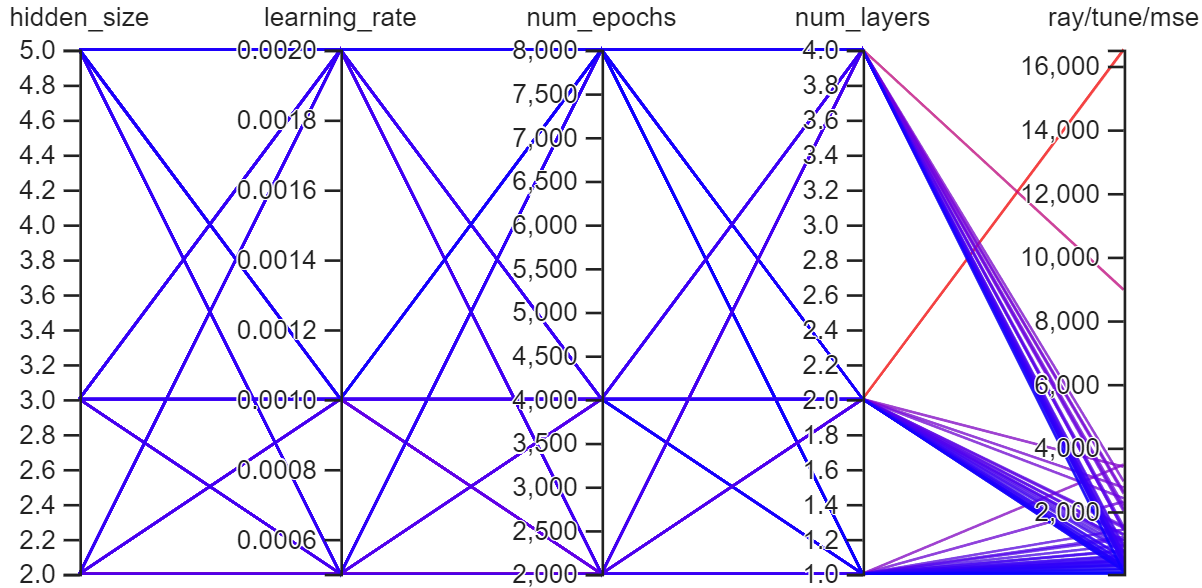

In [ ]:
# best hyperparameters
best_trial = analysis.get_best_trial(metric='mse', mode='min', scope='all')
min_mse = best_trial.metric_analysis['mse']['avg']
print(f'Min MSE: {min_mse}')
best_trial_config = best_trial.config
print(f'Best trial config: {best_trial_config}')

Min MSE: 31.608720779418945
Best trial config: {'hidden_size': 3, 'learning_rate': 0.001, 'num_epochs': 10000, 'num_layers': 1}


In [ ]:
# training model using best hyperparameters
best_trial_config['num_epochs'] = 10000 # increasing num of epochs
yhat_data = train_model(best_config=best_trial_config)

Epoch: 0, Loss: 0.2835
Epoch: 100, Loss: 0.1225
Epoch: 200, Loss: 0.0229
Epoch: 300, Loss: 0.0085
Epoch: 400, Loss: 0.0055
Epoch: 500, Loss: 0.0031
Epoch: 600, Loss: 0.0017
Epoch: 700, Loss: 0.0010
Epoch: 800, Loss: 0.0007
Epoch: 900, Loss: 0.0005
Epoch: 1000, Loss: 0.0004
Epoch: 1100, Loss: 0.0004
Epoch: 1200, Loss: 0.0003
Epoch: 1300, Loss: 0.0003
Epoch: 1400, Loss: 0.0002
Epoch: 1500, Loss: 0.0002
Epoch: 1600, Loss: 0.0002
Epoch: 1700, Loss: 0.0002
Epoch: 1800, Loss: 0.0001
Epoch: 1900, Loss: 0.0001
Epoch: 2000, Loss: 0.0001
Epoch: 2100, Loss: 0.0001
Epoch: 2200, Loss: 0.0001
Epoch: 2300, Loss: 0.0001
Epoch: 2400, Loss: 0.0001
Epoch: 2500, Loss: 0.0001
Epoch: 2600, Loss: 0.0001
Epoch: 2700, Loss: 0.0001
Epoch: 2800, Loss: 0.0001
Epoch: 2900, Loss: 0.0001
Epoch: 3000, Loss: 0.0001
Epoch: 3100, Loss: 0.0001
Epoch: 3200, Loss: 0.0001
Epoch: 3300, Loss: 0.0001
Epoch: 3400, Loss: 0.0001
Epoch: 3500, Loss: 0.0001
Epoch: 3600, Loss: 0.0001
Epoch: 3700, Loss: 0.0001
Epoch: 3800, Loss: 0.000

In [ ]:
# shutting down ray runtime
ray.shutdown()

### 6. Results

In [ ]:
# function for plotting actual and predicted data
def plt_graph(start_time, end_time, period, test_line=False):
    plt.xlim(start_time, end_time)
    if test_line:
        plt.axvline(x=start_time_test, c='r', linestyle='--')
    # plotting actual data
    plt.plot(stock_price_df.index.to_pydatetime(), y_data, label='Actual Data')
    # plotting predicted data
    plt.plot(stock_price_df.index.to_pydatetime(), yhat_data, label='Predicted Data')
    plt.title(f'Time-Series Prediction ({period} Period)')
    plt.legend()
    plt.show()

#### All period

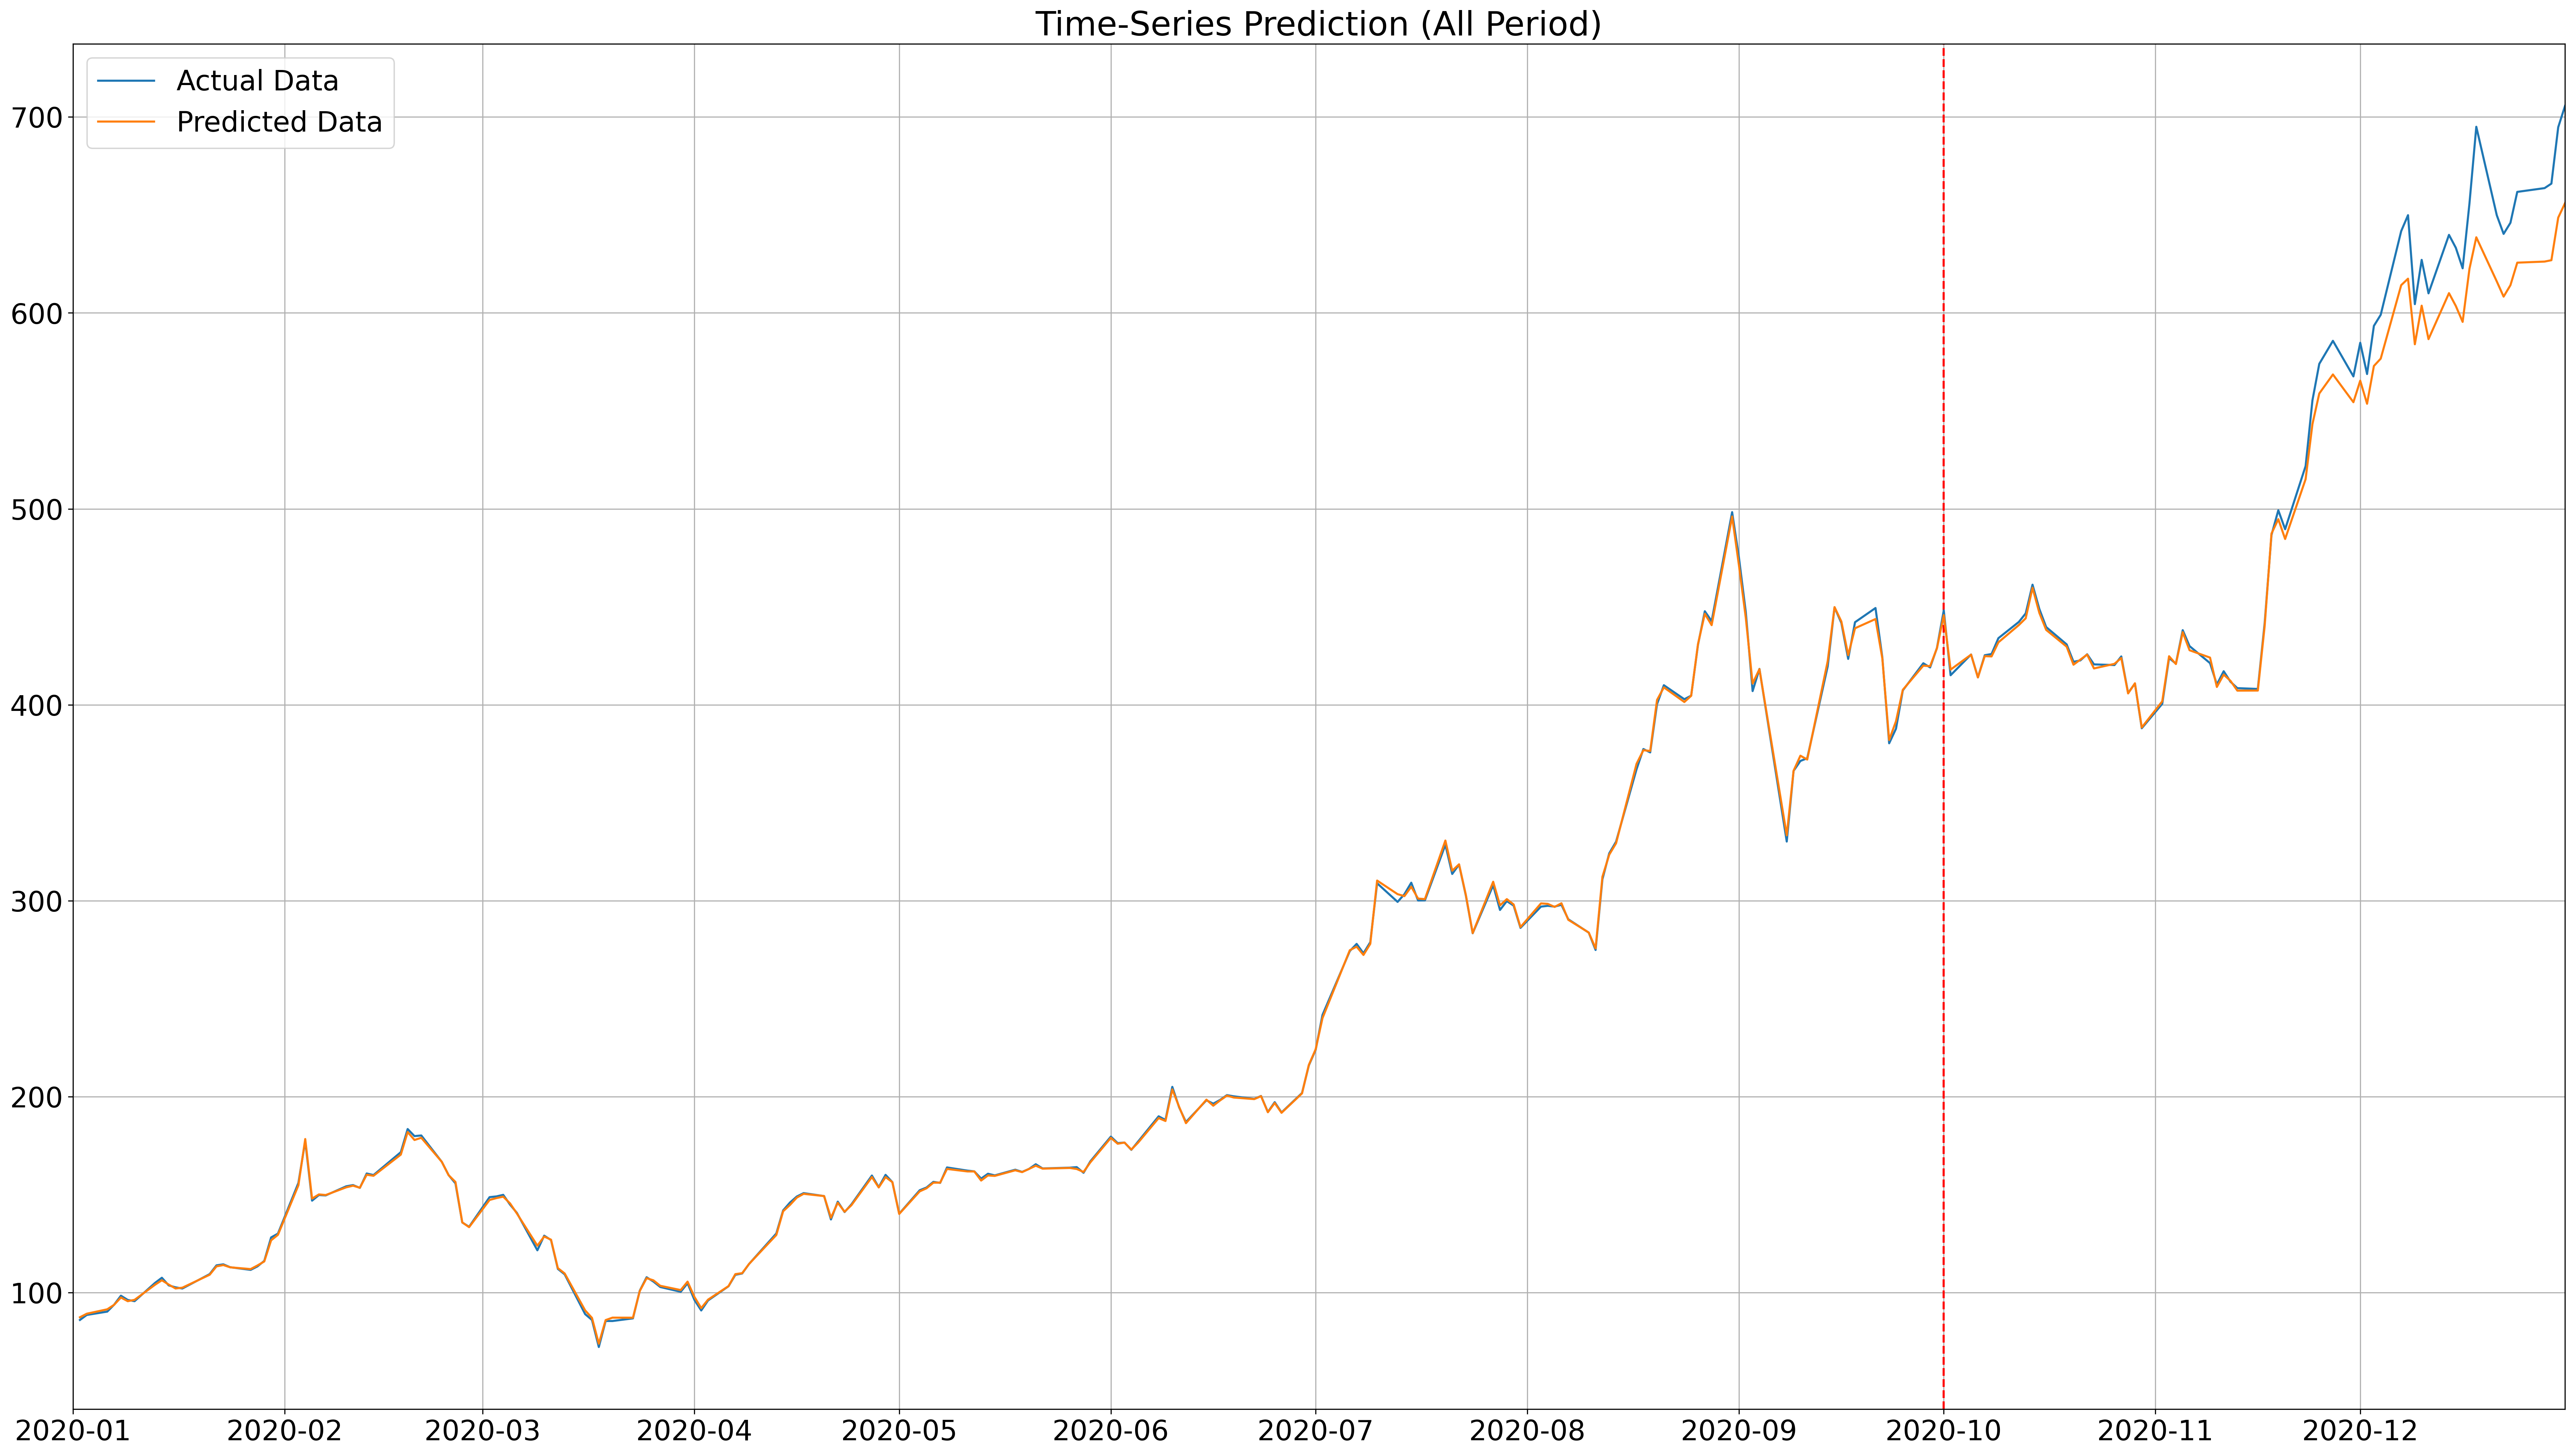

In [ ]:
# plotting all period
period = 'All'
plt_graph(start_time_all, end_time_all, period, True)

In [ ]:
mse = calc_mse(y_data, yhat_data)
print(f'MSE ({period}): {mse}')

MSE (All): 98.6361083984375


#### Training period

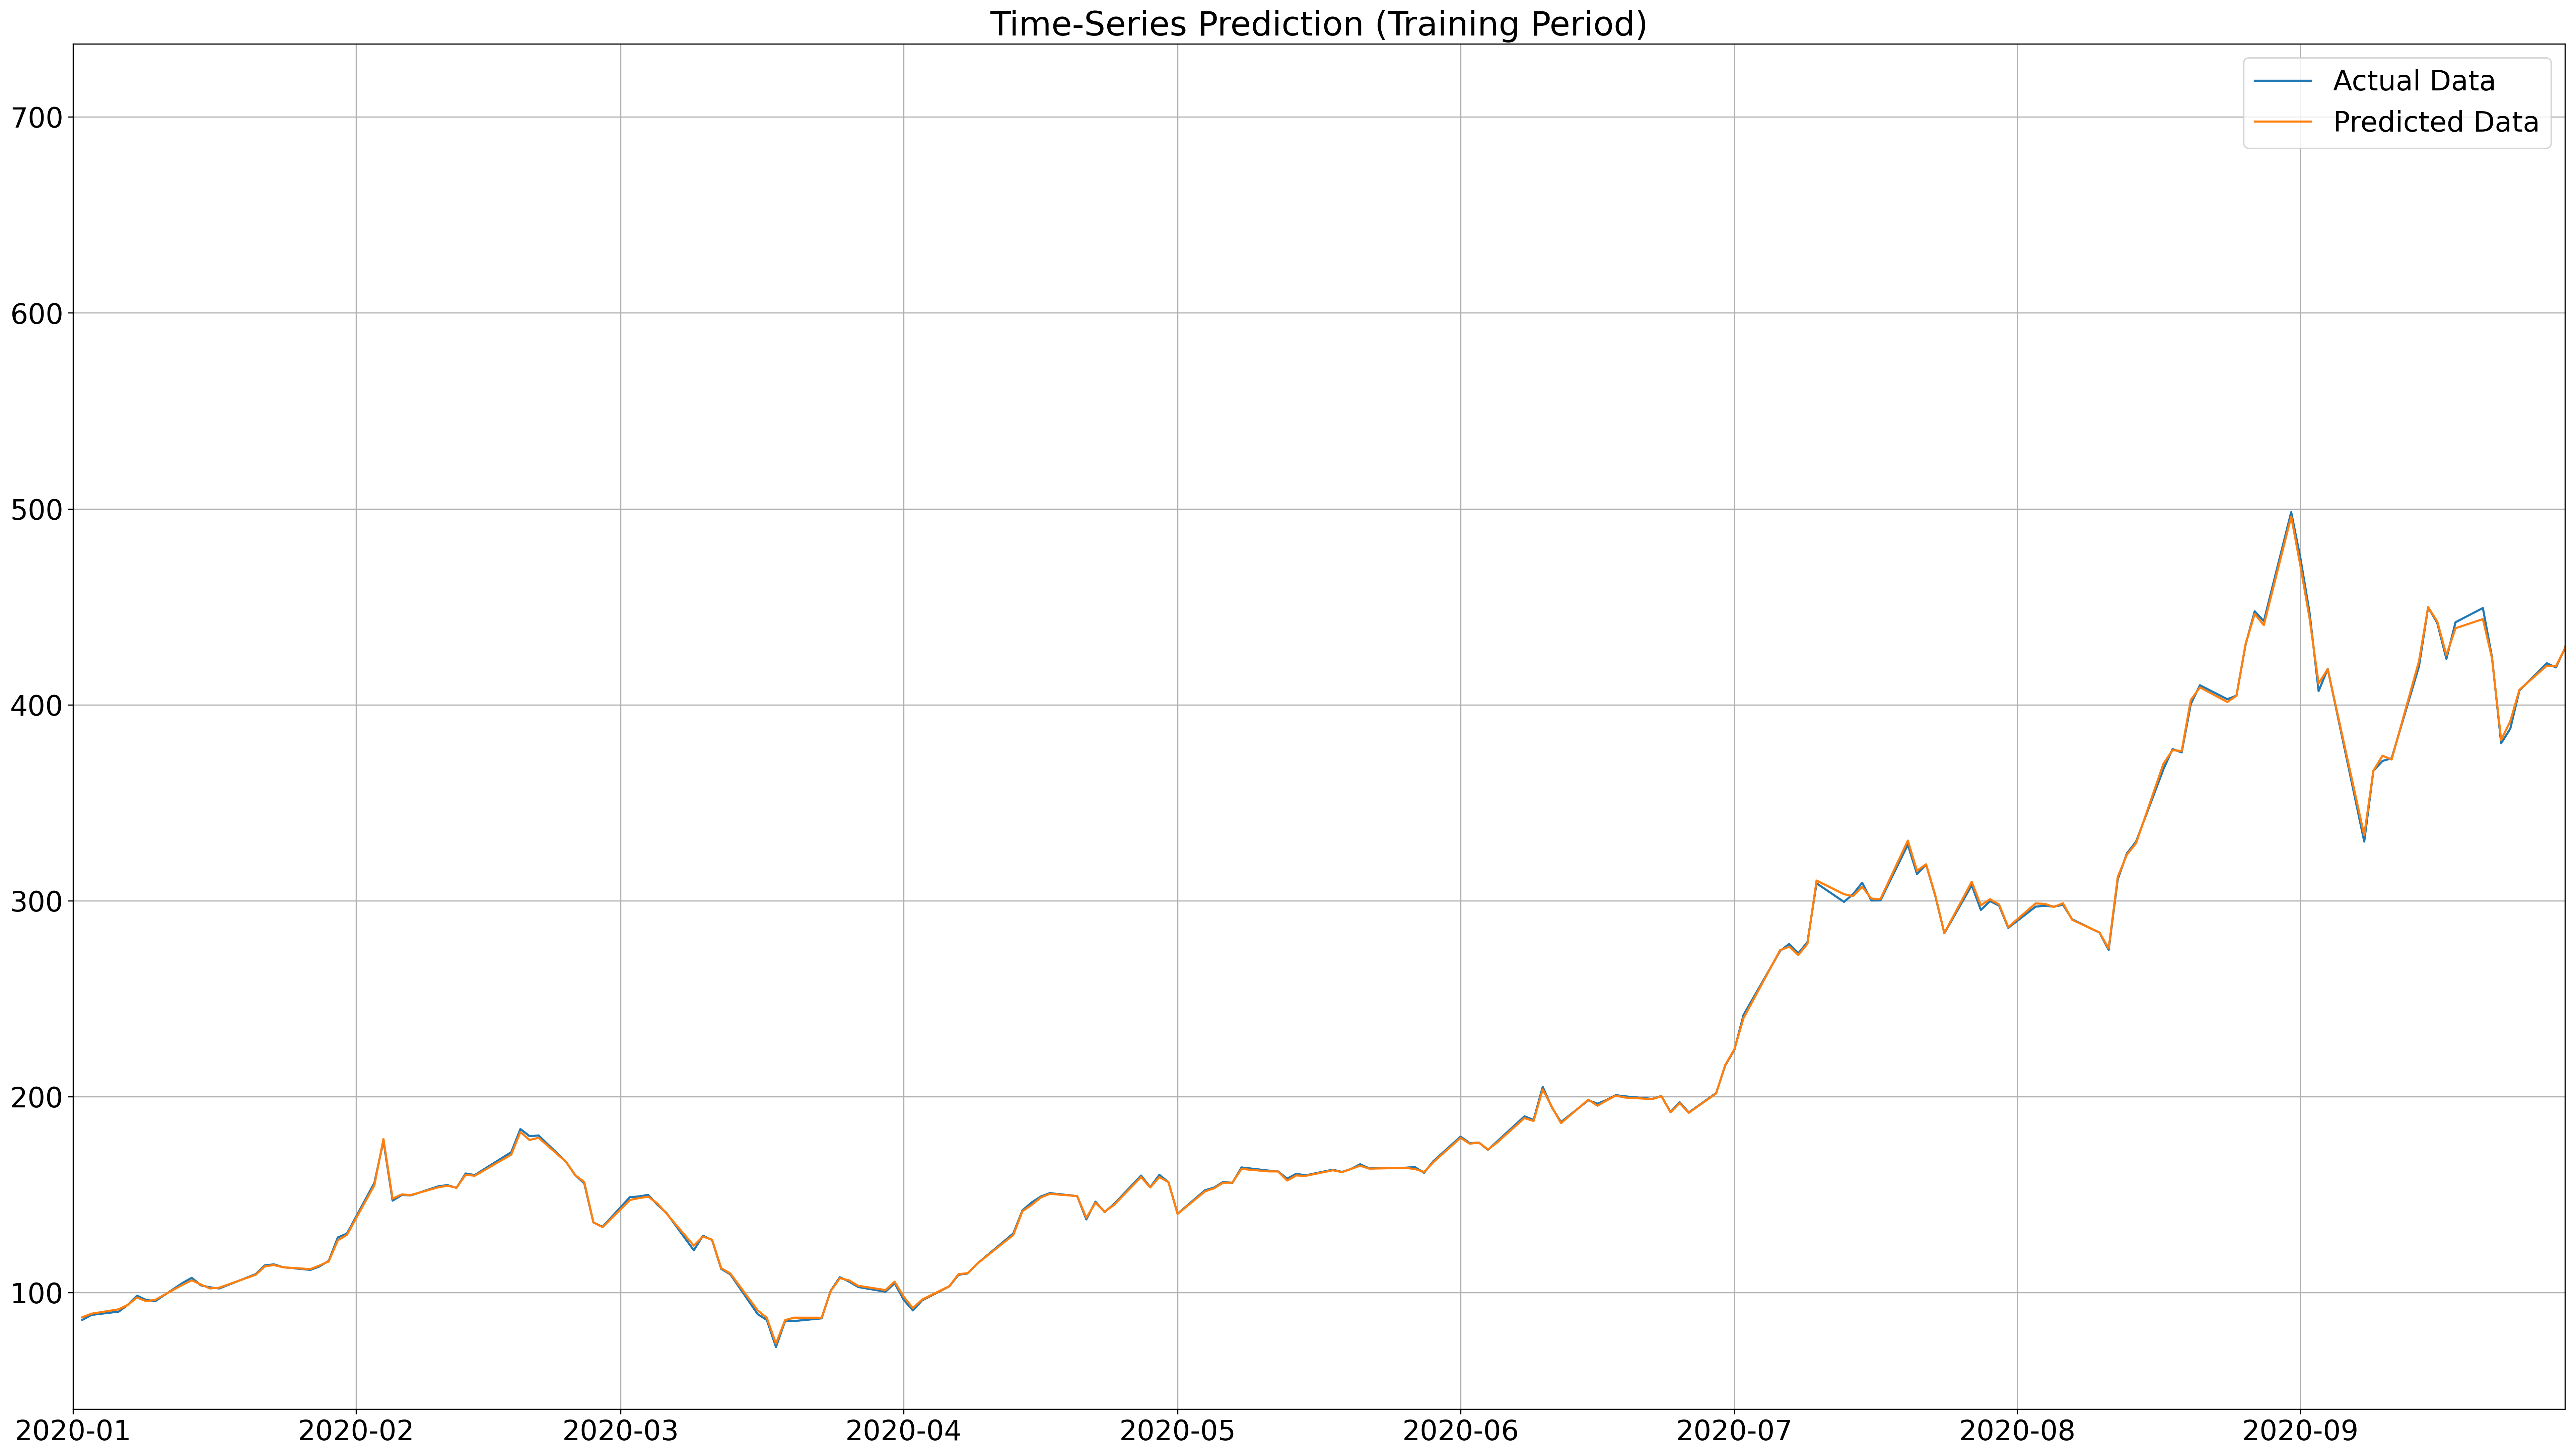

In [ ]:
# plotting training period
period = 'Training'
plt_graph(start_time_all, end_time_train, period)

In [ ]:
mse = calc_mse(y_data[:n_split], yhat_data[:n_split])
print(f'MSE ({period}): {mse}')

MSE (Training): 1.495889663696289


#### Testing period

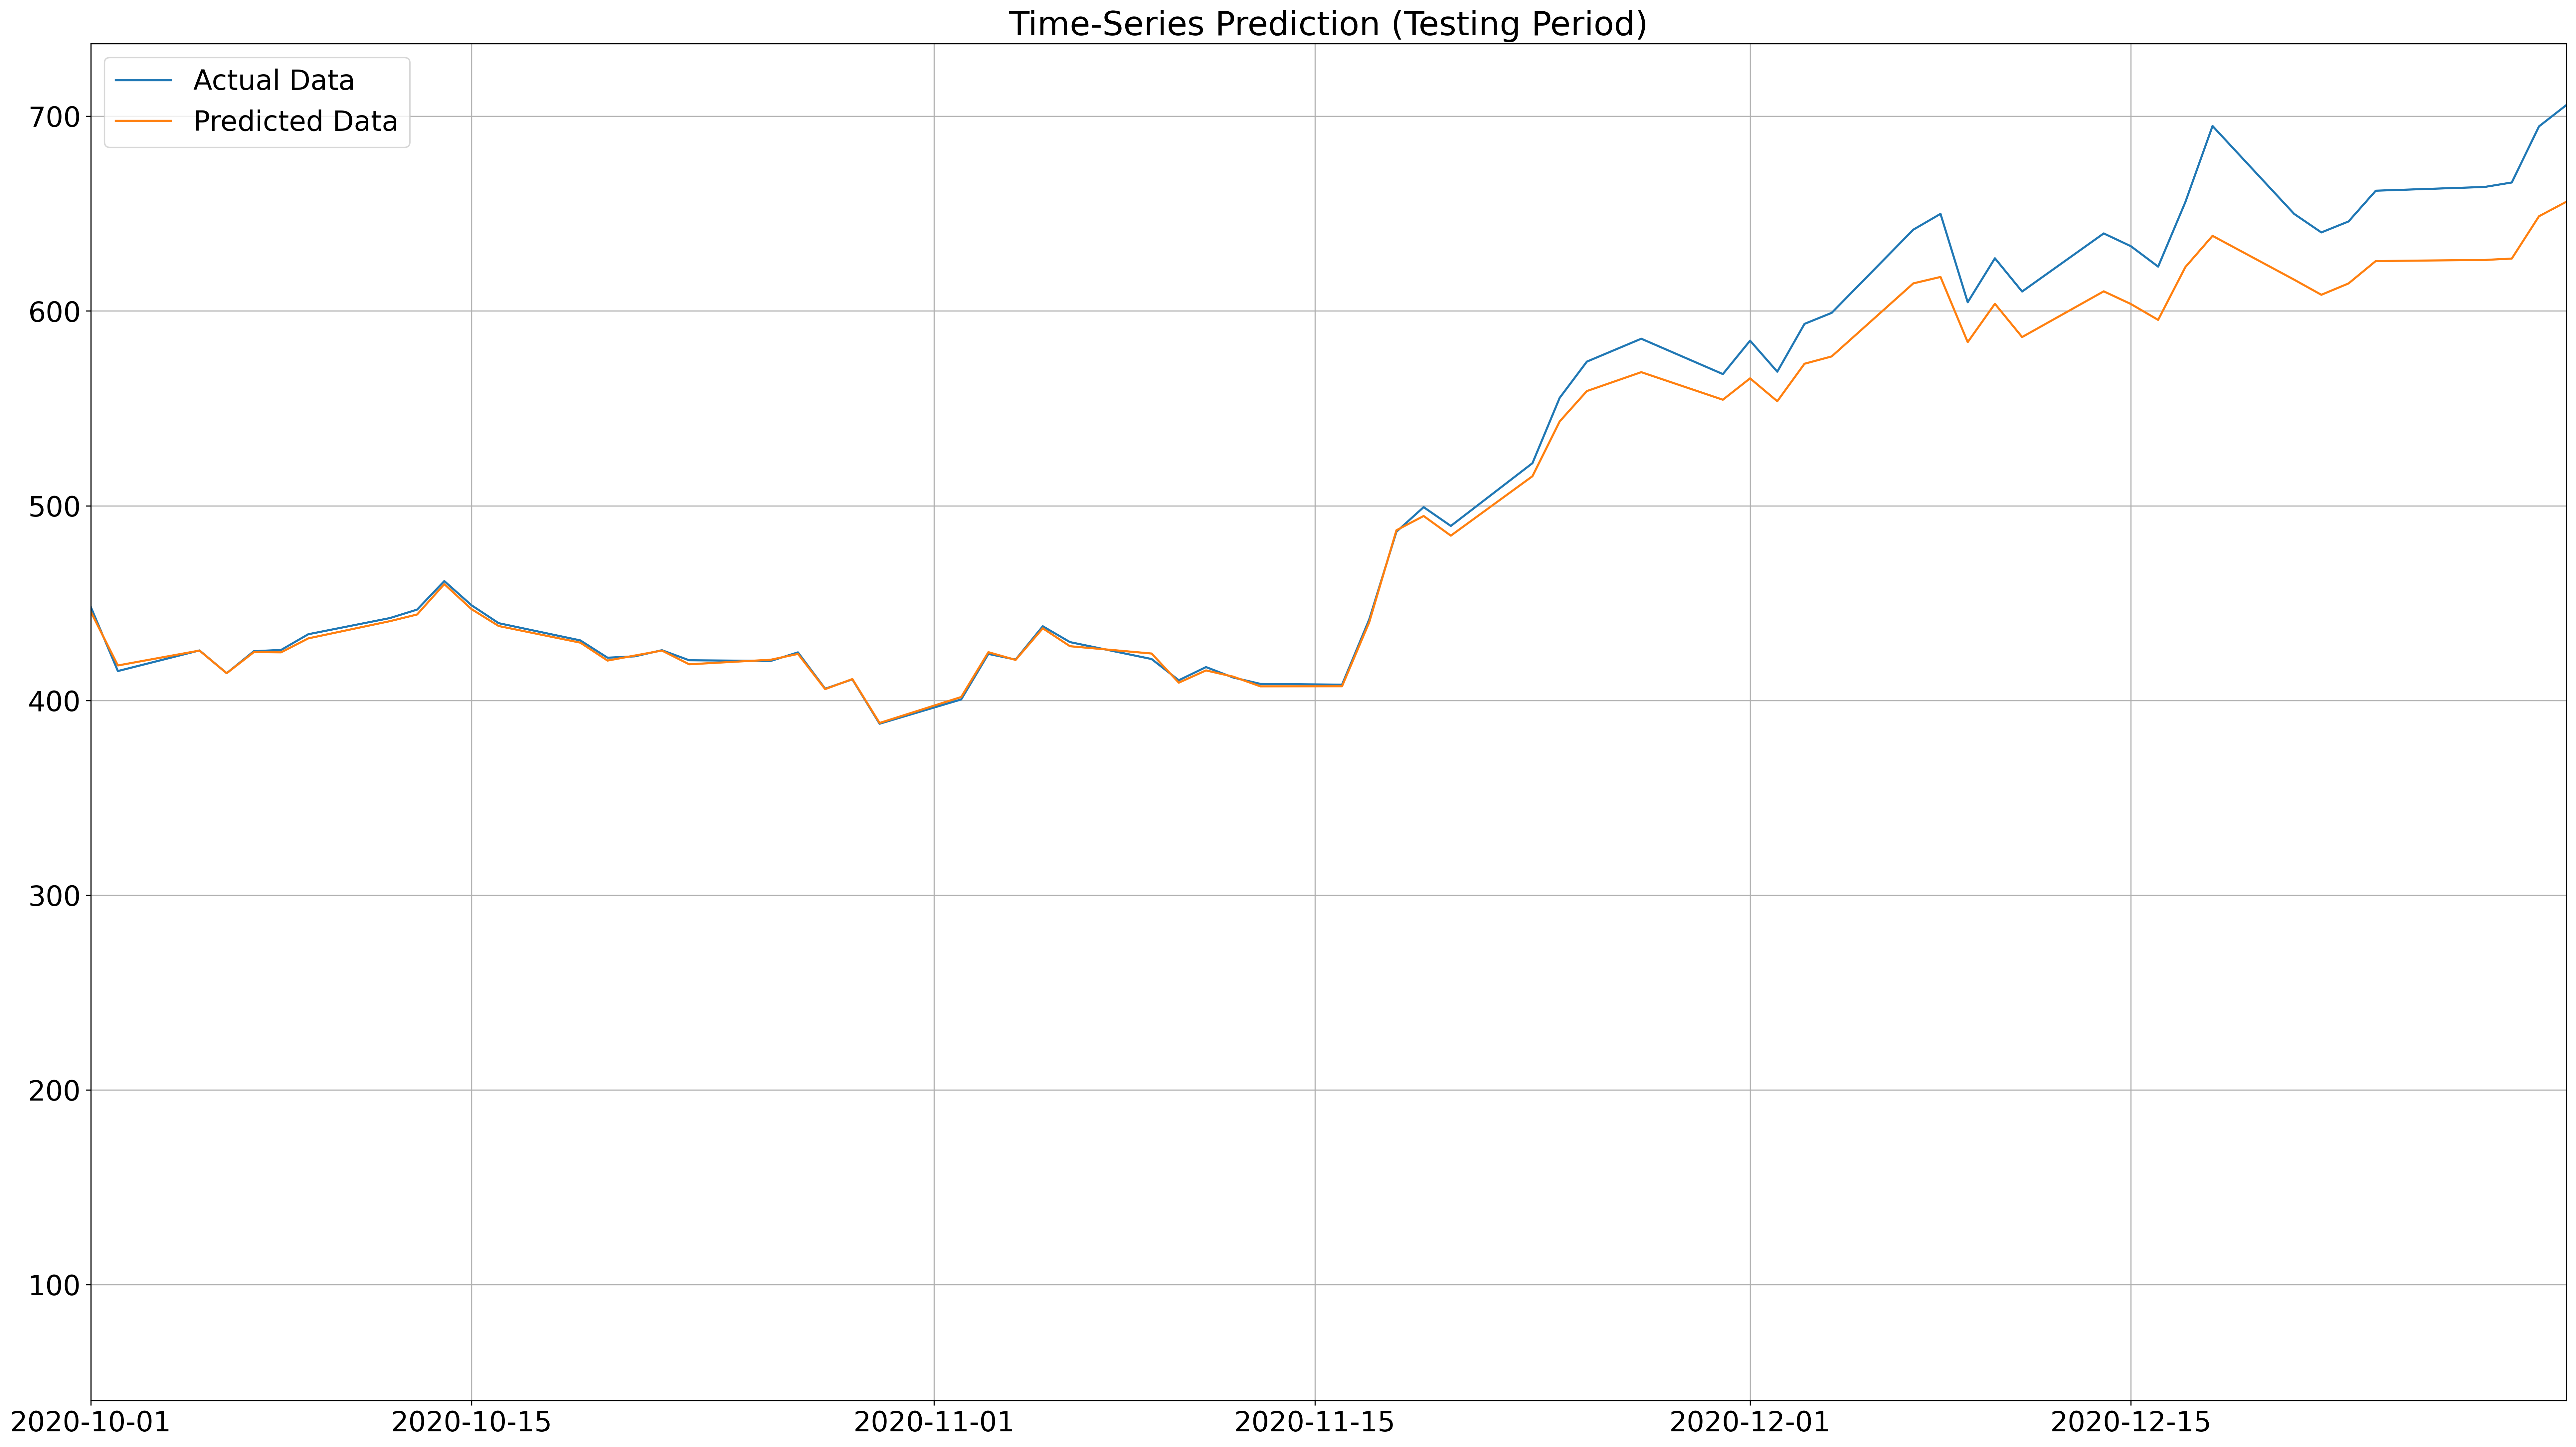

In [ ]:
# plotting testing period
period = 'Testing'
plt_graph(start_time_test, end_time_all, period)

In [ ]:
mse = calc_mse(y_data[n_split:], yhat_data[n_split:])
print(f'MSE ({period}): {mse}')

MSE (Testing): 385.5033264160156
